In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gwpy.time import to_gps, from_gps
from gwpy.segments import Segment
from gwpy.spectrogram import Spectrogram
from gwpy.timeseries import TimeSeries

before next section, you have to download all shown .csv files in: 

https://zenodo.org/record/5649212#.Y2PeY-xBzAN

and save them in a folder named glitch for the sake of searching speed.

In [2]:
# obtain all glitch time
def all_glitch_time():
    
    glitch_address = './glitch/'
    run = ['O1','O2','O3a','O3b']
    ifo = ['H1','L1']
    all_glitch_time = []

    for i in range(len(run)):
        for j in range(len(ifo)):
            ifo_run = ifo[j] + '_' + run[i] + '.csv'
            filename = glitch_address + ifo_run
            #print(filename)
            df = pd.read_csv(filename)
            gpstime = df['event_time'].tolist()
            #print(gpstime)
            all_glitch_time.append(gpstime)
            
    n_glitch = len(run)*len(ifo)
    return n_glitch,all_glitch_time

In [3]:
n_glitch,gpstime_glitch = all_glitch_time()

here you need to download another file named 4OGC_top.txt from:

https://github.com/gwastro/4-ogc/tree/master/search

and put it in a folder called o4gw.

sorry for the trouble:P

In [4]:
# obtain top 94 o4gw time
def top_search_time():
    
    file_address = './o4gw/4OGC_top.txt'
    search_name = []
    search_time = []

    with open(file_address) as file:
        data=file.read().splitlines()
        for i in range(1,len(data)):
            data[i] = data[i].split()
            search_name.append(data[i][1])
            search_time.append(float(data[i][2]))
        file.close()

    return search_time,search_name

In [5]:
gpstime_search,name_search = top_search_time()

In [6]:
# search for overlaps
match_search = []
match_glitch = []
match_time = []
match_glitch_number = []
match_glitch_row = []
for i in range(len(gpstime_search)):
    for j in range(n_glitch):
        for k in range(len(gpstime_glitch[j])):
            if abs(gpstime_glitch[j][k]-gpstime_search[i])<=1:
                match_search.append(name_search[i])
                match_glitch.append(gpstime_glitch[j][k])
                match_time.append(gpstime_search[i])
                match_glitch_number.append(j)
                match_glitch_row.append(k)

In [7]:
print(len(match_glitch_number))

24


In [8]:
# fetch glitch data
def glitch_locate(number,row):
    if number==0:
        ifo_run = 'H1_O1.csv'
    elif number==1:
        ifo_run = 'L1_O1.csv'
    elif number==2:
        ifo_run = 'H1_O2.csv'
    elif number==3:
        ifo_run = 'L1_O2.csv'
    elif number==4:
        ifo_run = 'H1_O3a.csv'
    elif number==5:
        ifo_run = 'L1_O3a.csv'
    elif number==6:
        ifo_run = 'H1_O3b.csv'
    else:
        ifo_run = 'L1_O3b.csv'
        
    glitch_address = './glitch/'
    filename = glitch_address + ifo_run
    df = pd.read_csv(filename)
    #event = df.loc[df['event_time'] == time]
    event = df.iloc[row]
    link = df.iloc[row]['url1']

    return ifo_run,event,link

In [9]:
# matched events quick look
glitch_event = []
glitch_link = []
for i in range(len(match_glitch_number)):
    ifo_run,event,link = glitch_locate(match_glitch_number[i],match_glitch_row[i])
    glitch_event.append(event)
    glitch_link.append(link)
    
for i in range(len(glitch_event)):
    print(match_search[i])
    print('from',ifo_run)
    print('event time:',match_time[i])
    print('glitch time:',match_glitch[i])
    print('glitch: ',glitch_link[i])
    print('\n')

GW170814_103043
from L1_O3b.csv
event time:  1186741861.5336914
glitch time:  1186741861.50976
glitch:  ?


GW190412_053044
from L1_O3b.csv
event time:  1239082262.1677246
glitch time:  1239082262.14453
glitch:  https://panoptes-uploads.zooniverse.org/production/subject_location/3023f393-752d-42e0-a62f-cea549d96dfd.png


GW190519_153544
from L1_O3b.csv
event time:  1242315362.3842773
glitch time:  1242315362.37891
glitch:  https://panoptes-uploads.zooniverse.org/production/subject_location/6409a530-dc5e-40d4-bf1c-9a49f5663af4.png


GW190521_030229
from L1_O3b.csv
event time:  1242442967.4423828
glitch time:  1242442967.44141
glitch:  https://panoptes-uploads.zooniverse.org/production/subject_location/105b45c5-87b1-4798-b15c-504a947595ae.png


GW190521_074359
from L1_O3b.csv
event time:  1242459857.4658203
glitch time:  1242459857.45996
glitch:  https://panoptes-uploads.zooniverse.org/production/subject_location/d214fdb0-e726-432b-b4c9-2904fdcc0b4d.png


GW190521_074359
from L1_O3b.csv


In [14]:
# draw glitch Q transform and save picture
def make_scan(event_time, ifo):


  try:
    print("Getting the Timeseries data")
    data = TimeSeries.fetch_open_data(ifo, event_time-10, event_time+10)
    print("Obtaining the Q transform")
    q_data = data.q_transform(qrange=(8,8),frange = (20,512), 
                             outseg=Segment(event_time-1,event_time+1),tres=0.001, fres = 0.01, whiten = True)

  except ValueError:
    q_data = False
    print('Data surrounding this time is not available, please try another gpstime')

  if q_data:
    print("Plotting the Q transform")
    plot = q_data.plot(figsize=[12, 8])
    ax = plot.gca()
    ax.set_xscale('seconds')
    ax.set_ylabel('Frequency [Hz]',fontsize=16)
    #ax.set_ylim(10,512)
    ax.set_yscale('log')
    ax.grid(False)
    cbar = ax.colorbar(cmap='viridis',clim=(0, 25),location='right')
    cbar.set_label(r"$\mathrm{Normalized \ energy}$",fontsize=16)
    plt.savefig(str(event_time)+'.png',dpi=200)
    plt.show()
    print("All done.")
  else:
    pass

Getting the Timeseries data
Obtaining the Q transform
Plotting the Q transform


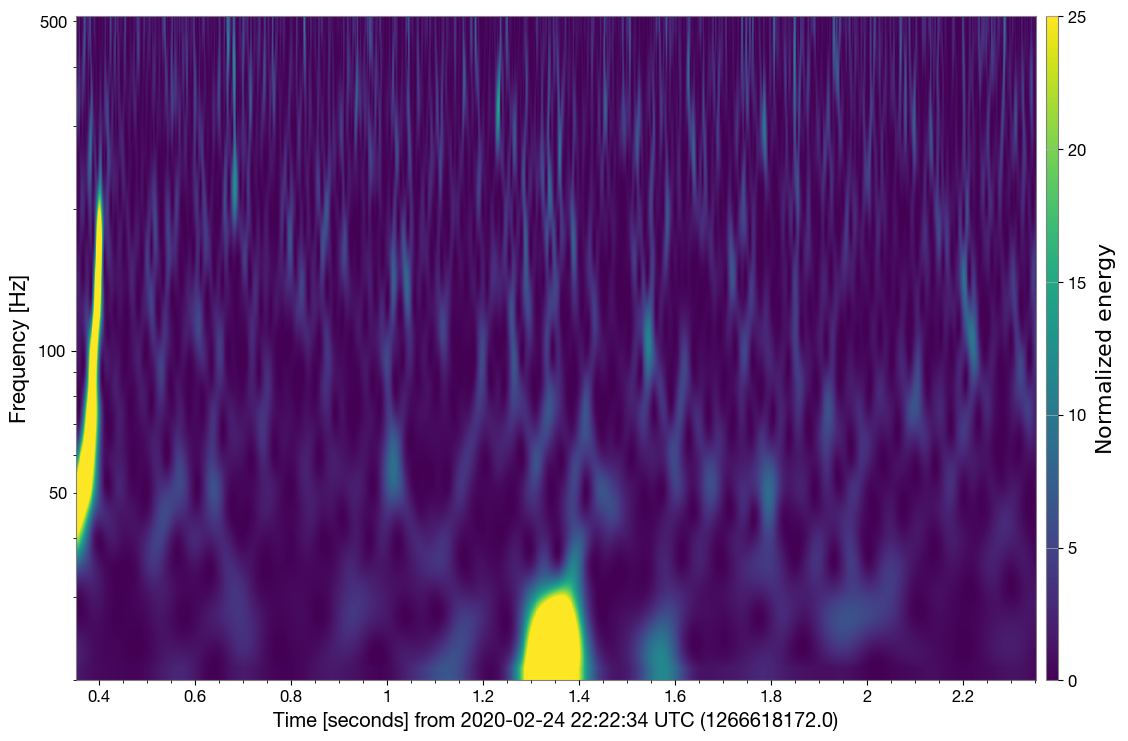

All done.
Getting the Timeseries data
Obtaining the Q transform
Plotting the Q transform


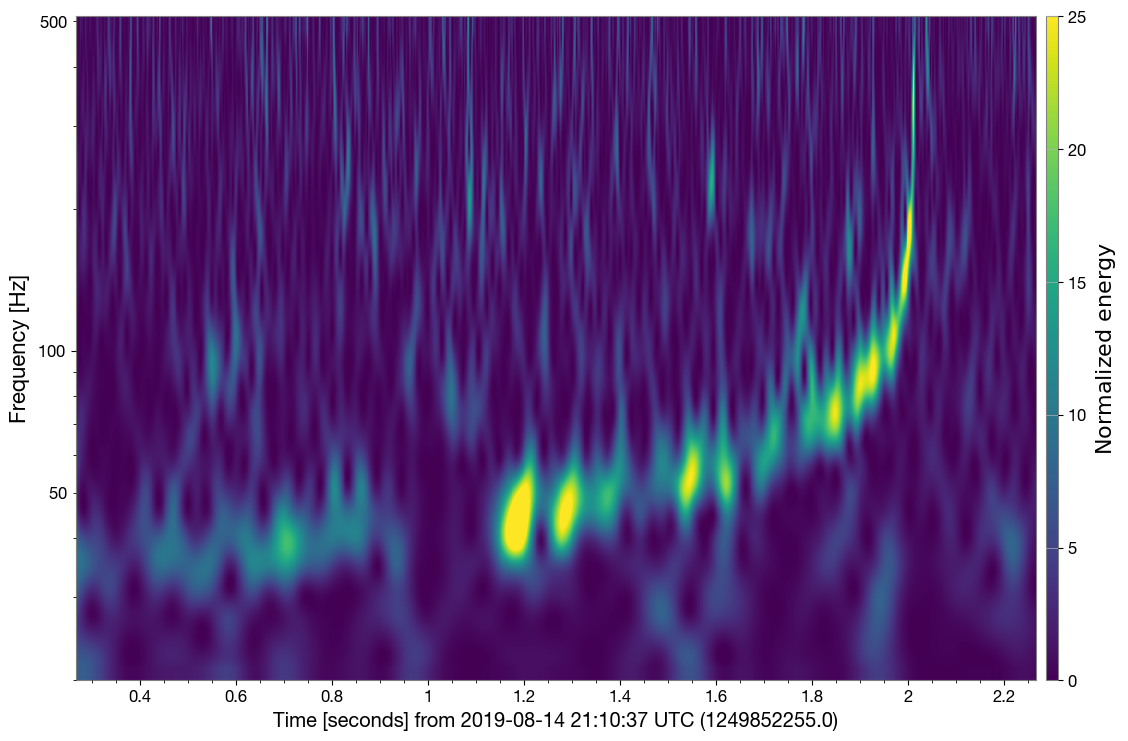

All done.


In [15]:
make_scan(1249852256.26562,'L1')